In [1]:
import cv2 

img = cv2.imread('/home/likcos/DataSets/sportimages/sportimages/basket/basket2_0001.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

21 28 3 3


# Convolutional Neural Networks

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [3]:
dirname = os.path.join(os.getcwd(),'/home/likcos/DataSets/sportimages/sportimages')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /home/likcos/DataSets/sportimages/sportimages/
/home/likcos/DataSets/sportimages/sportimages/americano 1


/home/likcos/DataSets/sportimages/sportimages/natacion 9348


/home/likcos/DataSets/sportimages/sportimages/futbol 5172


/home/likcos/DataSets/sportimages/sportimages/beisball 7617


/home/likcos/DataSets/sportimages/sportimages/f1 7752


/home/likcos/DataSets/sportimages/sportimages/ciclismo 5053


/home/likcos/DataSets/sportimages/sportimages/golf 7533


/home/likcos/DataSets/sportimages/sportimages/boxeo 9768


/home/likcos/DataSets/sportimages/sportimages/tenis 7125


/home/likcos/DataSets/sportimages/sportimages/basket 8937


Directorios leidos: 10
Imagenes en cada directorio [9349, 5172, 7617, 7752, 5053, 7533, 9768, 7125, 8937, 8822]
suma Total de imagenes en subdirs: 77128


# Creamos las etiquetas

In [4]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  77128


In [5]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 americano
1 natacion
2 futbol
3 beisball
4 f1
5 ciclismo
6 golf
7 boxeo
8 tenis
9 basket


In [6]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [7]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 3')

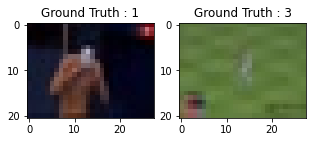

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

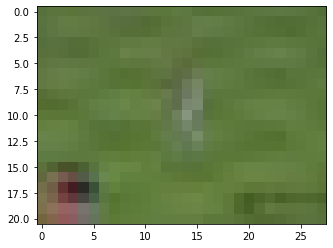

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [10]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 1
After conversion to one-hot: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [11]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [12]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [13]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [14]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [16]:
sport_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 32)                200736    
                                                        

In [15]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [16]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20


2024-01-25 22:47:31.769791: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 348291216 exceeds 10% of free system memory.


769/772 [============================>.] - ETA: 0s - loss: 2.2511 - accuracy: 0.1544

2024-01-25 22:47:39.643314: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 87078096 exceeds 10% of free system memory.


772/772 [==============================] - 8s 10ms/step - loss: 2.2510 - accuracy: 0.1546 - val_loss: 2.1287 - val_accuracy: 0.3137
Epoch 2/20
772/772 [==============================] - 8s 11ms/step - loss: 2.0957 - accuracy: 0.2529 - val_loss: 1.9039 - val_accuracy: 0.4552
Epoch 3/20
772/772 [==============================] - 9s 12ms/step - loss: 1.9265 - accuracy: 0.3290 - val_loss: 1.6967 - val_accuracy: 0.5446
Epoch 4/20
772/772 [==============================] - 10s 13ms/step - loss: 1.7752 - accuracy: 0.3863 - val_loss: 1.5159 - val_accuracy: 0.5938
Epoch 5/20
772/772 [==============================] - 10s 13ms/step - loss: 1.6459 - accuracy: 0.4349 - val_loss: 1.3775 - val_accuracy: 0.6371
Epoch 6/20
772/772 [==============================] - 10s 13ms/step - loss: 1.5348 - accuracy: 0.4734 - val_loss: 1.2532 - val_accuracy: 0.6645
Epoch 7/20
772/772 [==============================] - 11s 15ms/step - loss: 1.4354 - accuracy: 0.5077 - val_loss: 1.1556 - val_accuracy: 0.6892
Epoch 

In [22]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("/home/likcos/setDocto/sport.h5")

2023-10-31 07:55:24.251832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,11,14,32]
	 [[{{node inputs}}]]
2023-10-31 07:55:24.271671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-10-31 07:55:24.461872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,11,14,32]
	 [[{{node inputs}}]]
2023-10

INFO:tensorflow:Assets written to: /home/likcos/setDocto/sport.h5py/assets


INFO:tensorflow:Assets written to: /home/likcos/setDocto/sport.h5py/assets


# Evaluamos la red

In [23]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

 49/483 [==>...........................] - ETA: 0s - loss: 0.7048 - accuracy: 0.8195

2023-10-31 07:55:31.016566: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 108845856 exceeds 10% of free system memory.


483/483 [==============================] - 1s 2ms/step - loss: 0.7207 - accuracy: 0.8049


In [24]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.7206676006317139
Test accuracy: 0.8048748970031738


In [25]:
sport_train.history

{'loss': [2.274190664291382,
  2.1802561283111572,
  2.045179605484009,
  1.8963977098464966,
  1.7624967098236084,
  1.6410114765167236,
  1.5433735847473145,
  1.4543966054916382,
  1.3776878118515015,
  1.3199374675750732,
  1.2633285522460938,
  1.2131398916244507,
  1.1800554990768433,
  1.133784294128418,
  1.095059871673584,
  1.0712194442749023,
  1.0397975444793701,
  1.0110794305801392,
  0.9898505210876465,
  0.9696773886680603],
 'accuracy': [0.1462693214416504,
  0.22341524064540863,
  0.29798829555511475,
  0.35718482732772827,
  0.4053402543067932,
  0.4454326331615448,
  0.47827231884002686,
  0.5074654221534729,
  0.5376511812210083,
  0.5539596080780029,
  0.5740159153938293,
  0.5925933718681335,
  0.60057532787323,
  0.6193958520889282,
  0.6316120028495789,
  0.6378517746925354,
  0.6518911719322205,
  0.6618990898132324,
  0.669982373714447,
  0.6789368391036987],
 'val_loss': [2.209636688232422,
  2.064708709716797,
  1.8642598390579224,
  1.675637125968933,
  1.

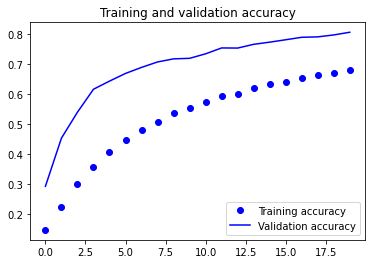

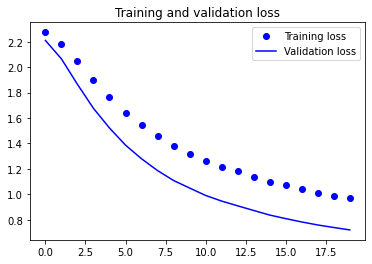

In [26]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
predicted_classes2 = sport_model.predict(test_X)

 51/483 [==>...........................] - ETA: 0s

2023-10-31 07:55:53.420853: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 108845856 exceeds 10% of free system memory.


483/483 [==============================] - 1s 2ms/step


In [28]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [29]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

# Aprendamos de los errores: Qué mejorar

Found 12416 correct labels


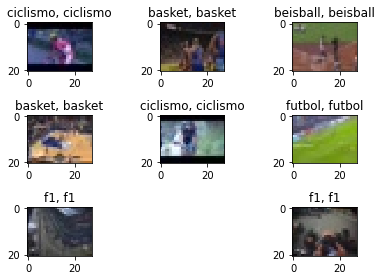

In [30]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 3010 incorrect labels


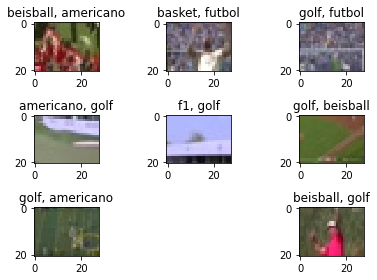

In [31]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [4]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

NameError: name 'nClasses' is not defined

In [3]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['test/golf_0113.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

FileNotFoundError: [Errno 2] No such file or directory: 'test/golf_0113.jpg'